<a href="https://colab.research.google.com/github/amarnepali/Dogs_vs_Cats/blob/master/project_on_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jokiro","key":"d1bd92c8d0773281d6cc1508c7d864c2"}'}

In [0]:
! pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 95% 321M/337M [00:02<00:00, 94.5MB/s]
100% 337M/337M [00:02<00:00, 127MB/s] 


In [6]:
!unzip cell-images-for-detecting-malaria.zip

Archive:  cell-images-for-detecting-malaria.zip
   creating: cell_images/
   creating: cell_images/Parasitized/
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extracting: cell_images/Parasitized/C

In [0]:
import numpy as np
import os
import json
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
def load_data(data_path, target_size=(128,128)):
    img_arr_img = []
    filelist_img = glob.glob(data_path+"*.png")
    image_paths = sorted(filelist_img)
    
    for image_path in image_paths:
        try:
            image = cv2.imread(image_path)
            image = cv2.resize(image, dsize=target_size)#interpolation=cv2.INTER_CUBIC) #/255.0
            #cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
            img_arr_img.append(image)
        except (RuntimeError, TypeError,NameError) as e:
            print(e)
            pass
    return np.asarray(img_arr_img), image_paths 

In [0]:
path_infected = '/content/cell_images/Parasitized/'
path_uninfected='/content/cell_images/Uninfected/'
X_Infected,Filenames_infected = load_data(path_infected)
X_Uninfected,Filenames_uninfected= load_data(path_uninfected)

In [25]:
X_Infected.shape


(13779, 128, 128, 3)

In [26]:
X_Uninfected.shape

(13779, 128, 128, 3)

In [0]:
# we stack vertically X_Infected and X_Uninfected to make the data tensor X

X = np.vstack((X_Uninfected,X_Infected))

labels = [0]*X_Uninfected.shape[0] + [1]*X_Infected.shape[0]

X_train, X_test, Y_train, Y_test = train_test_split(X,labels,test_size=0.1,random_state=42)


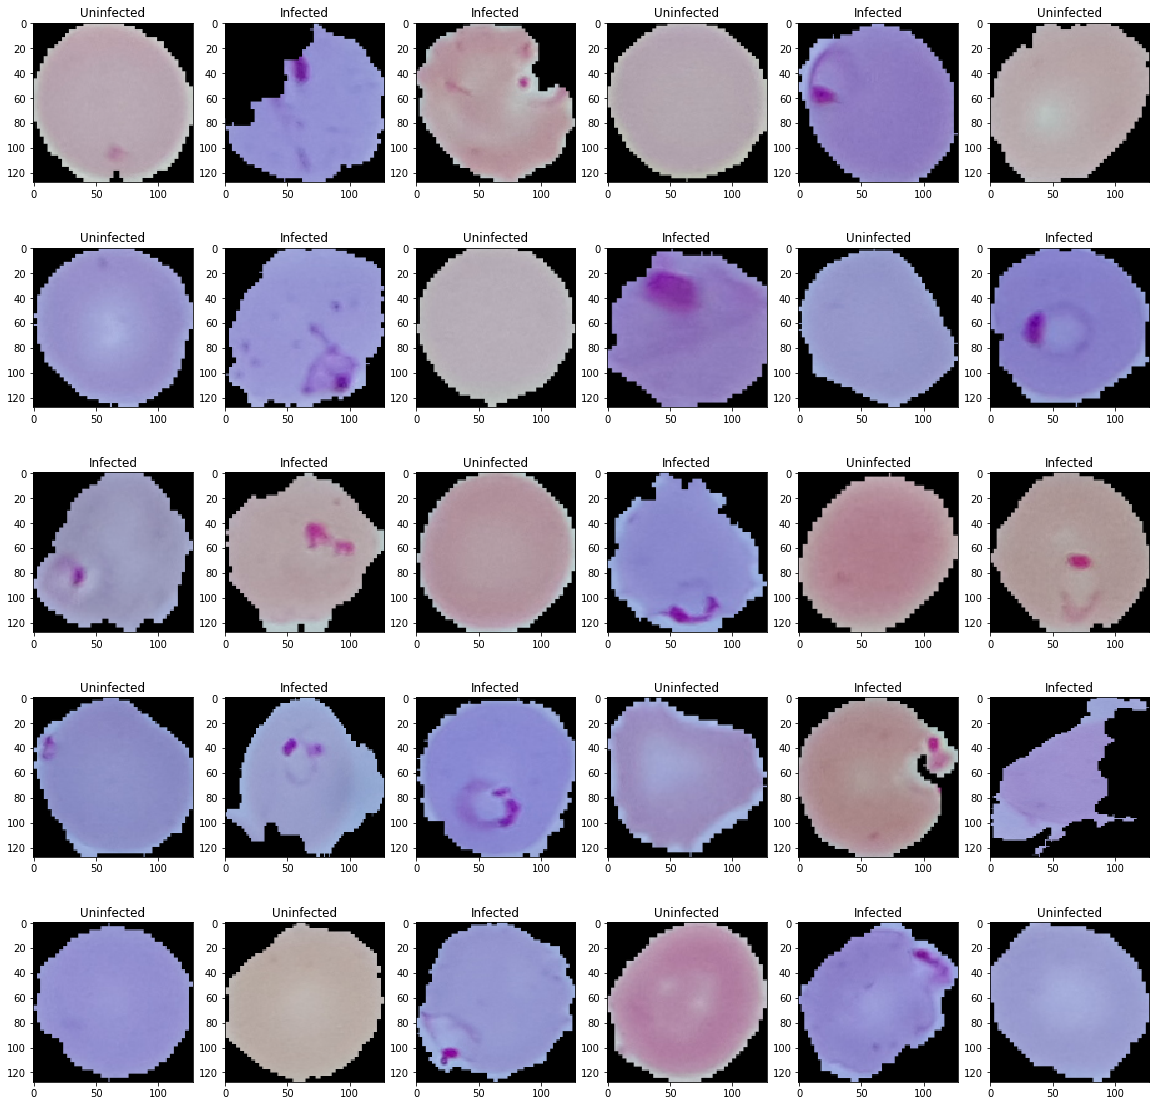

In [39]:
fig =plt.figure(figsize=(20,20))
col = 6
row = 5

for i in range(1,col*row +1):
  fig.add_subplot(row, col,i)
  plt.imshow(X_train[i])
  if y_train[i] == 0:
    plt.title('Uninfected')
  else:
    plt.title('Infected')
    
plt.show()


In [40]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation

from sklearn import preprocessing


Using TensorFlow backend.


In [0]:
K.set_image_data_format('channels_last')   # this gives format as [rows][columns][channels]
np.random.seed(0)


def create_model(input_shape, with_summary):
  model = Sequential()
  model.add(Conv2D(10,kernel_size=5,padding="same",input_shape=input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(20,kernel_size=3,padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(30,kernel_size=3,padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  
  model.add(Flatten())
  model.add(Dense(units=30,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=10,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=5, activation='relu'))
  model.add(Dropout(0.1))
  
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  
  if with_summary:
    model.summary()
    
  return model
  

In [0]:
def save_history(hist, filepath):
  with open(filepath, 'w') as f:
    json.dump(hist.history,f)
    
def plot_loss(history_filepath):
  with open(history_filepath) as json_data:
    history =json.load(json_data)
    print(history)
    
    print(history.keys())
    plt.plot(history['loss'])
    plt.plot(history['acc'])
    plt.title('Training metrics')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','accuracy'], loc='upper left')
    plt.show()

In [44]:
input_shape=(128,128,3)
model=create_model(input_shape=input_shape, with_summary=True)

W0626 16:15:43.127259 140487362156416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 16:15:43.173765 140487362156416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 16:15:43.184543 140487362156416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 16:15:43.229179 140487362156416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0626 16:15:43.288498 140487362156416 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 10)      760       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
__________

In [46]:
hist = model.fit(X_train,Y_train,batch_size=512,epochs=20)

Epoch 1/20
24802/24802 [==============================] - 356s 14ms/step - loss: 0.9909 - acc: 0.5202
Epoch 2/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.6797 - acc: 0.5691
Epoch 3/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.6627 - acc: 0.5943
Epoch 4/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.6434 - acc: 0.6184
Epoch 5/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.6225 - acc: 0.6539
Epoch 6/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.5970 - acc: 0.6809
Epoch 7/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.5824 - acc: 0.6956
Epoch 8/20
24802/24802 [==============================] - 346s 14ms/step - loss: 0.5654 - acc: 0.7099
Epoch 9/20
24802/24802 [==============================] - 347s 14ms/step - loss: 0.5686 - acc: 0.7039
Epoch 10/20
24802/24802 [==============================] - 347s 14ms/step - loss: 

In [47]:
print (model.evaluate(X_test,Y_test))
model.save_weights('/content/project_using_cnn_20ep.h5')

2756/2756 [==============================] - 14s 5ms/step
[0.1728624341406566, 0.9361393323657474]


{'loss': [0.9908951643339791, 0.6797494446449766, 0.6626565733241243, 0.6434270744073411, 0.622508823405388, 0.5969541153737821, 0.5824141971152326, 0.5653928222603187, 0.5685965467456772, 0.520993070072363, 0.49444207677667384, 0.4291859444336837, 0.36955566987011973, 0.30700833153536256, 0.28189525179551134, 0.26927783916928233, 0.23782159493446503, 0.21658002182092698, 0.21273421825694322, 0.1914653794658385], 'acc': [0.5202403034032251, 0.5690670105182647, 0.5943069106272637, 0.6184178693872644, 0.6538988792187802, 0.6808725103439126, 0.6955890655613707, 0.7098621076830414, 0.7038545278029792, 0.7439319408619541, 0.7598983951465093, 0.8050963631532585, 0.8397306667327035, 0.8781549874192985, 0.8964599627572176, 0.9052495765989802, 0.9223852914606849, 0.9308926699651978, 0.9328279977949884, 0.9408112248531533]}
dict_keys(['loss', 'acc'])


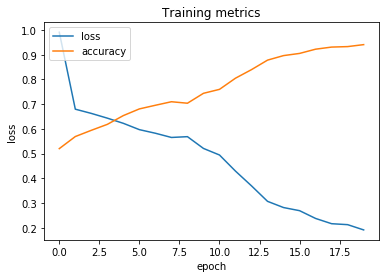

In [53]:
save_history(hist,filepath='/content/training_history.json')
plot_loss(history_filepath='/content/training_history.json')

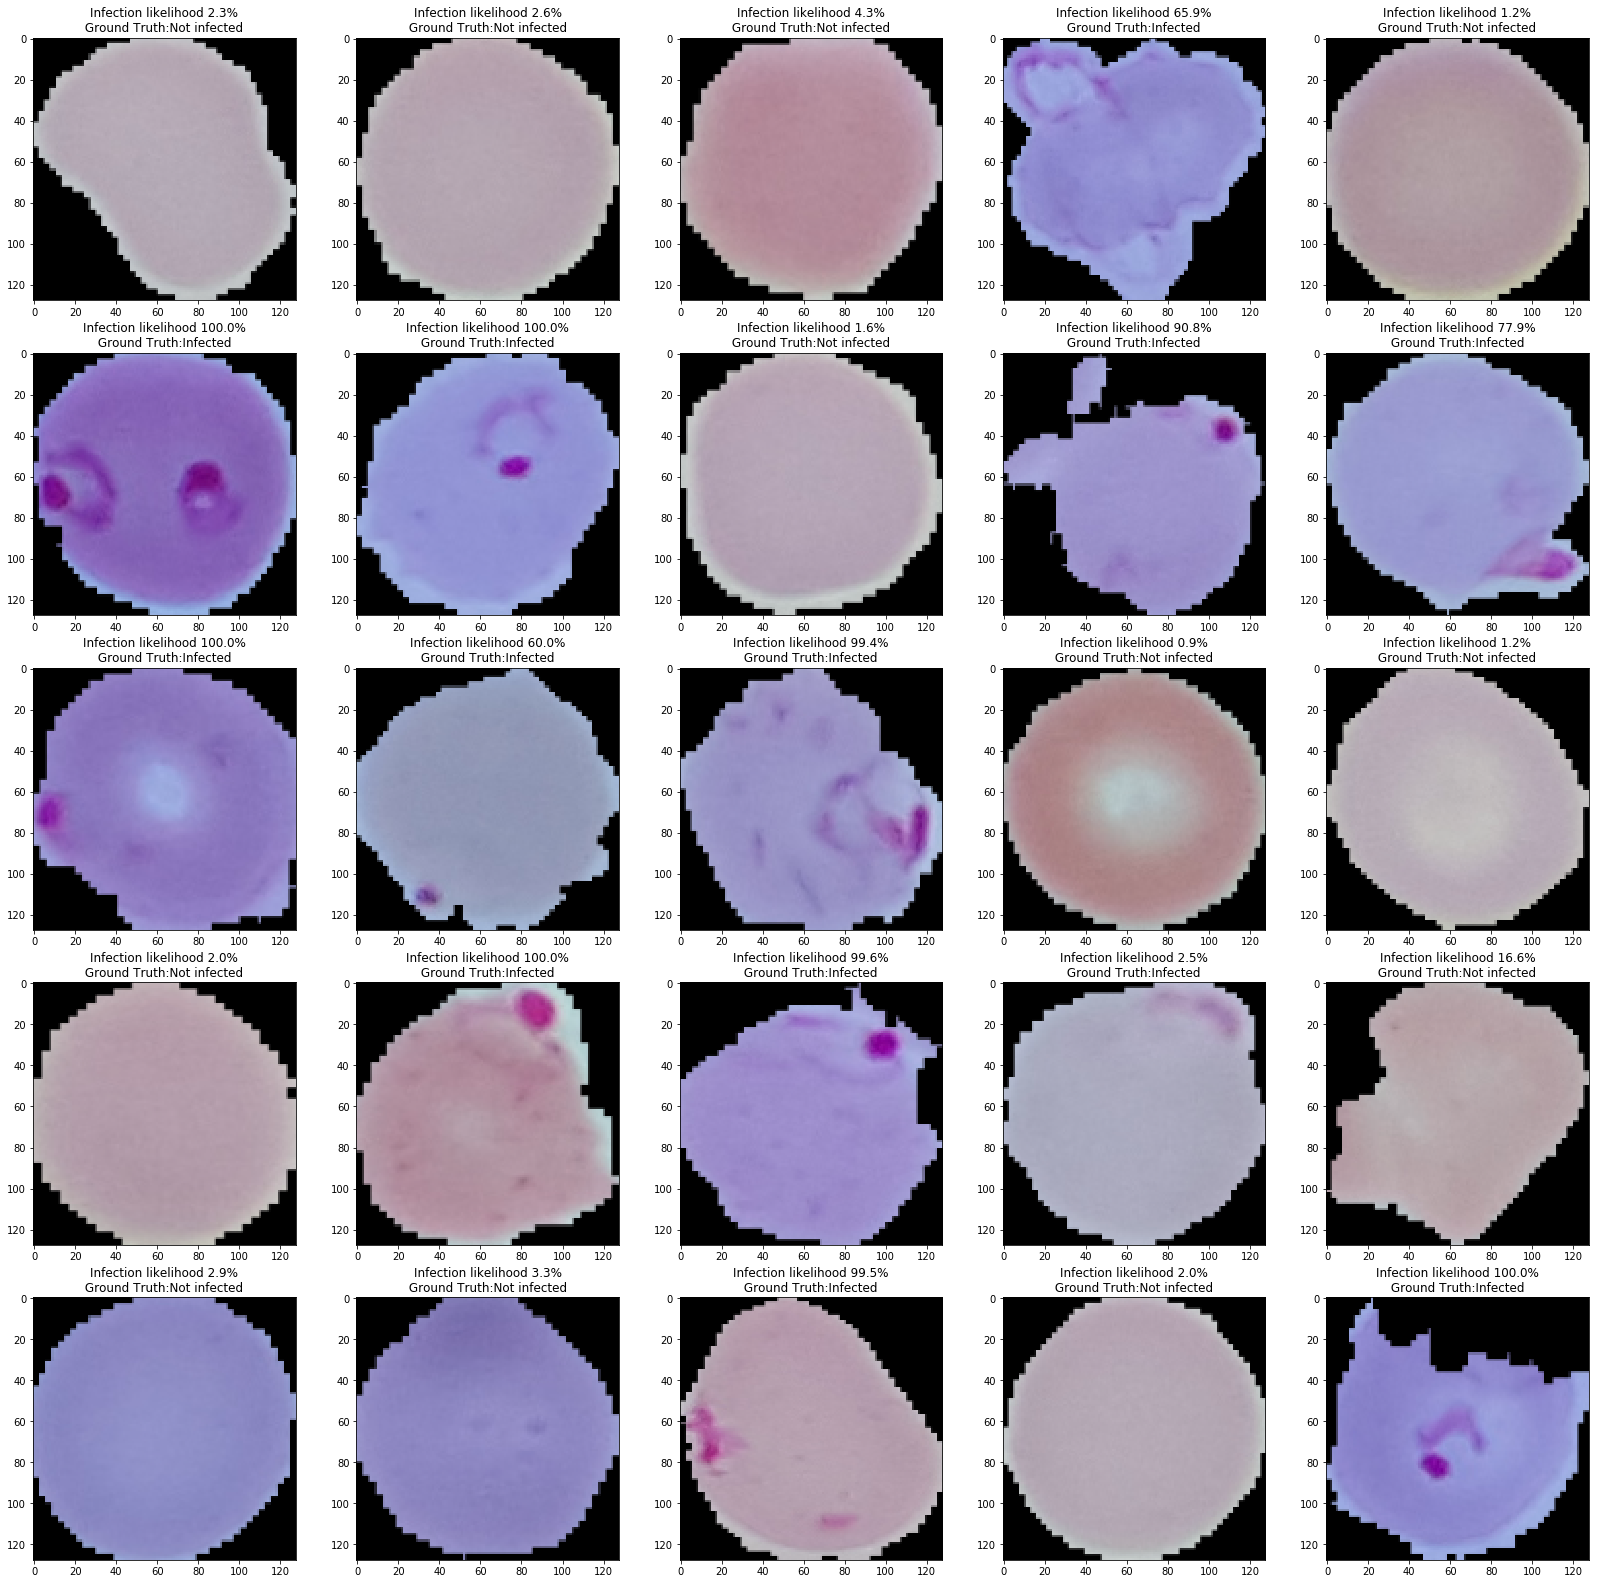

In [55]:
predictions = model.predict(X_test)

fig=plt.figure(figsize=(28, 28))
columns = 5
rows = 5
random_number = np.random.randint(0,X_test.shape[0]-26)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_test[i+random_number])
    gt = ['Not infected', 'Infected']
    plt.title('Infection likelihood {:.1%}\n Ground Truth:{} '.format(float(predictions[i+random_number]), gt[y_test[i+random_number]]))
    
plt.show()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

threshold = 0.65
predictions_final = [int(pred>threshold) for pred in predictions]

print(classification_report(y_test, predictions_final))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1407
           1       0.98      0.88      0.93      1349

    accuracy                           0.93      2756
   macro avg       0.94      0.93      0.93      2756
weighted avg       0.94      0.93      0.93      2756



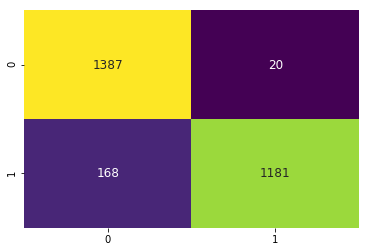

In [57]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()

draw_confusion_matrix(y_test, predictions_final)